## Uso y aplicación de los métodos de agrupamiento

Aprendizaje no supervisado

- Jaime 
- Jordi
- Alvaro Navarro Guzmán

In [1]:
from sklearn import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.decomposition import PCA

#### DataSet 1: Lung Disease

The first 5 variables are all blood tests which are thought
to be sensitive to liver disorders that might arise from
excessive alcohol consumption.

https://archive.ics.uci.edu/ml/datasets/liver+disorders

In [2]:
nms=["Mean corpuscular volume", "alkaline phosphotase","alanine aminotransferase", "aspartate aminotransferase",
     "gamma-glutamyl transpeptidase","half-pint aquivalents per day", "split"]

lung=pd.read_table('DataSets/Liver_Disease.csv', sep=';', names =nms )

#Eliminamos la variable "etiqueta" de este dataset y de esta forma transformamos el set de datos en uno en el que 
#desconocemos el agrupamiento.
lung=lung.iloc[:,0:6]
lung.sample(5)

,Mean corpuscular volume,alkaline phosphotase,alanine aminotransferase,aspartate aminotransferase,gamma-glutamyl transpeptidase,half-pint aquivalents per day
98,89,65,26,18,36,3.0
291,87,45,19,13,16,4.0
94,89,62,42,30,20,3.0
40,84,92,68,37,44,0.5
329,82,55,18,23,44,8.0


#### DataSet 2: Zoo Animals

A simple database containing 17 Boolean-valued attributes.

https://archive.ics.uci.edu/ml/datasets/zoo

In [3]:
zoo=pd.read_table('DataSets/Zoo_DataSet.csv', sep=';' , 
                  names = ["animal name", "hair", "feathers", "eggs","milk", "airborne", "aquatic", 
                           "predator", "toothed", "backbone", "breathes","venomous", "fins", "legs",
                           "tail", "domestic", "catsize", "type" ])

#Este será el set de datos del que conocemos el agrupamiento real
zoo.sample(5)

,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
80,slowworm,0,0,1,0,0,0,1,1,1,1,0,0,0,1,0,0,3
69,raccoon,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
24,flea,0,0,1,0,0,0,0,0,0,1,0,0,6,0,0,0,6
58,penguin,0,1,1,0,0,1,1,0,1,1,0,0,2,1,0,1,2
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1


#### 0. PREPROCESADO

In [5]:
# DataSet 1: Enfermedad del pulmón
####################################

# Eliminamos las filas en las que haya algún NaN
lung.dropna(inplace=True)
#Estandarizamos las columnas del dataset
standardizer = preprocessing.StandardScaler()
lung_std = standardizer.fit_transform(lung)
# Aplicamos una PCA para poder representar en 2D los atributos sobre los que aplicar las medidas de clustering
pca = PCA()
PCs_lung = pca.fit_transform(lung_std)
principal_lung = pd.DataFrame(data = PCs_lung[:,:2], columns = ['PC 1', 'PC 2'])



C:\Users\alvar\Anaconda3\envs\VIU\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alvar\Anaconda3\envs\VIU\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


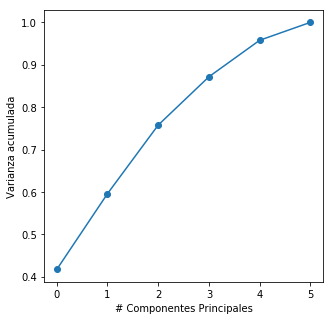

In [6]:
#Comprobamos la varianza acumulada por las PCs de la PCA
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
plt.xlabel('# Componentes Principales')
plt.ylabel('Varianza acumulada');
plt.show()

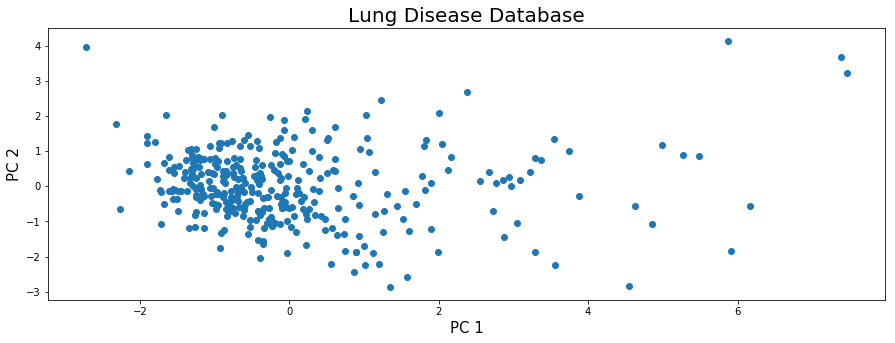

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(PCs_lung[:,0],PCs_lung[:,1])
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Lung Disease Database', fontsize = 20)
plt.show()

In [9]:
# DataSet 2: Animales del Zoo
#################################

# Separamos la primera y la última columna del dataframe
zoo_label=zoo.iloc[:,-1]
zoo=zoo.iloc[:,1:-1]


# Eliminamos las filas en las que haya algún NaN
zoo.dropna(inplace=True)
#Estandarizamos las columnas del dataset
standardizer = preprocessing.StandardScaler()
zoo_std = standardizer.fit_transform(zoo)
# Aplicamos una PCA para poder representar en 2D los atributos sobre los que aplicar las medidas de clustering
pca = PCA()
PCs_zoo = pca.fit_transform(zoo_std)
principal_zoo = pd.DataFrame(data = PCs_zoo[:,:2], columns = ['PC 1', 'PC 2'])



C:\Users\alvar\Anaconda3\envs\VIU\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alvar\Anaconda3\envs\VIU\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


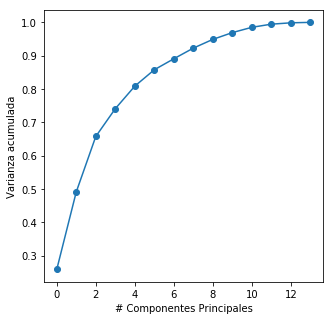

In [10]:
#Comprobamos la varianza acumulada por las PCs de la PCA
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
plt.xlabel('# Componentes Principales')
plt.ylabel('Varianza acumulada');
plt.show()

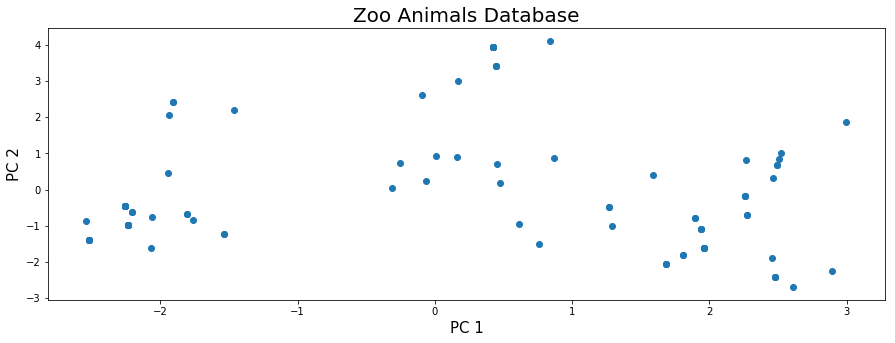

In [12]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(PCs_zoo[:,0],PCs_zoo[:,1])
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Zoo Animals Database', fontsize = 20)
plt.show()

#### 1. AGRUPAMIENTO POR PARTICIONES

#### 2. AGRUPAMIENTO JERÁRQUICO

#### 3. AGRUPAMIENTO ESPECTRAL

In [15]:
#datos Lung: PCs_lung
#datos Zoo: PCs_zoo, zoo_label

#### 4. AGRUPAMIENTO POR DENSIDAD

#### 5. AGRUPAMIENTO PROBABILÍSTICO